# <center>Тема 9. Анализ временных рядов в Python</center>
## <center>Часть 2. Смерти из-за несчастного случая в США</center>

Известно ежемесячное число смертей в результате случайного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

In [6]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

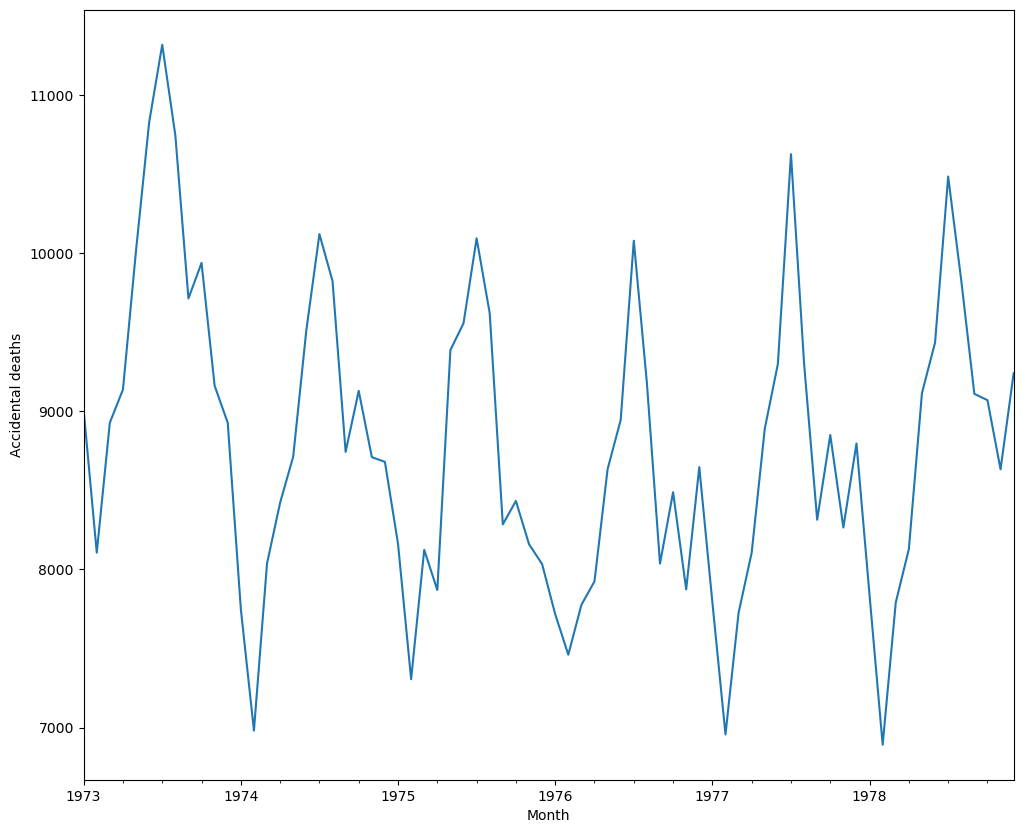

In [2]:
deaths = pd.read_csv('accidental-deaths-in-usa-monthly.csv',
                   index_col=['Month'], parse_dates=['Month'])
deaths.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'num_deaths'}, inplace=True)
deaths['num_deaths'].plot()
plt.ylabel('Accidental deaths');

In [15]:
#type(deaths['Month'])
deaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 1973-01-01 to 1978-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_deaths  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.102481


(-2.5557984096356776,
 0.10248122056865139,
 12,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 870.8496020346796)

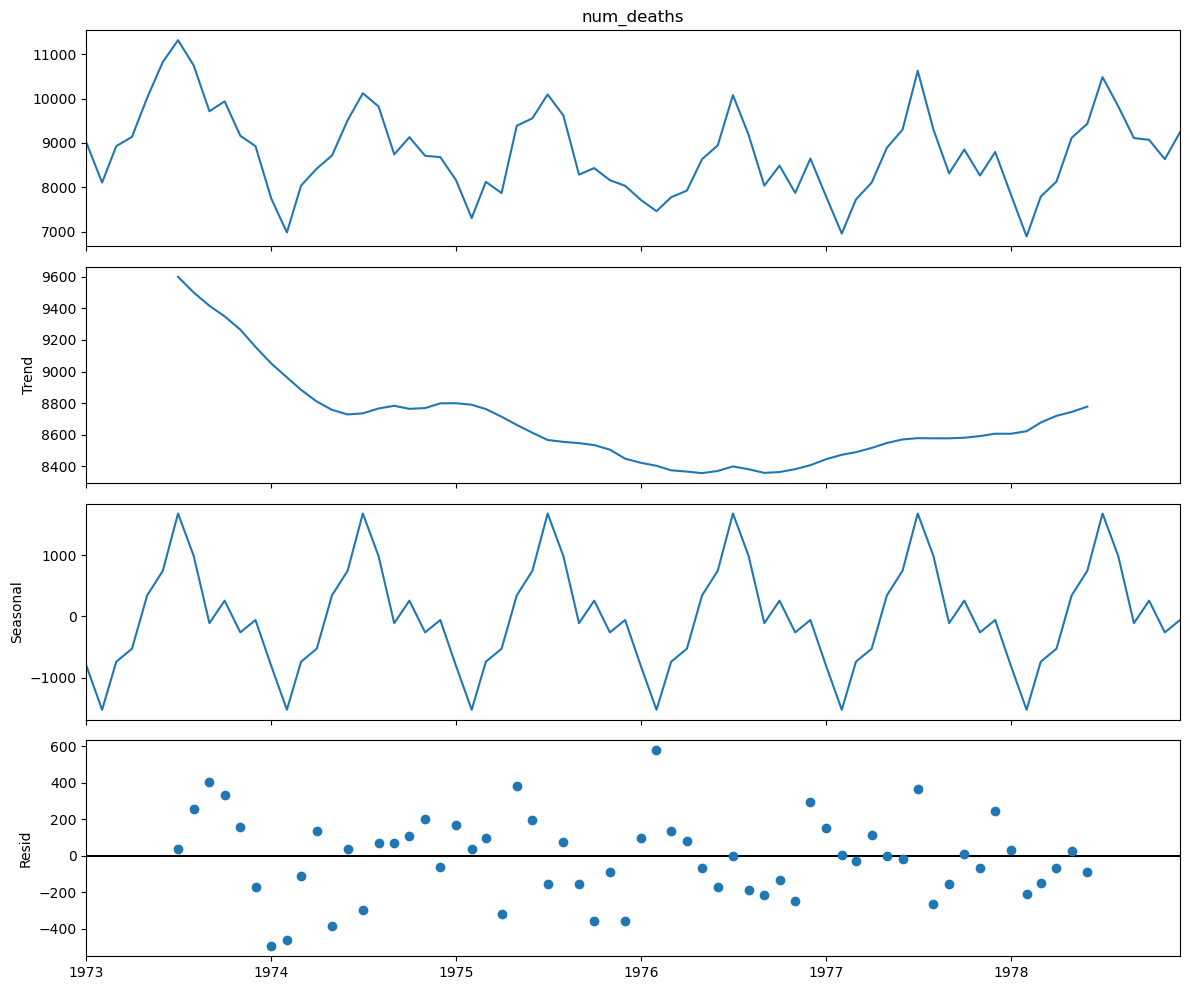

In [14]:
sm.tsa.seasonal_decompose(deaths['num_deaths']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths'])[1])
sm.tsa.stattools.adfuller(deaths['num_deaths'])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, но небольшой тренд остался. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014650


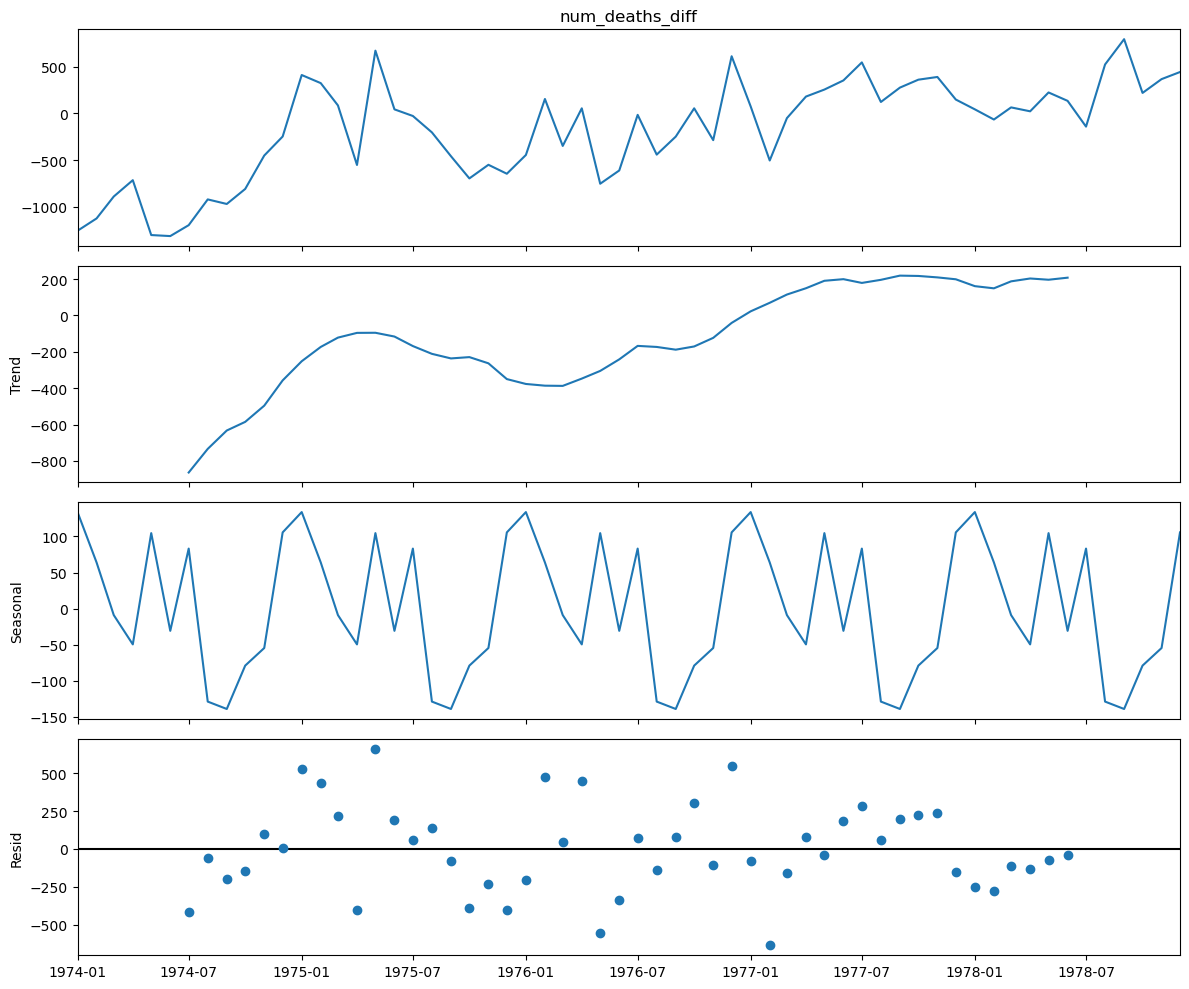

In [19]:
deaths['num_deaths_diff'] = deaths['num_deaths'] - deaths['num_deaths'].shift(12)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths_diff'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


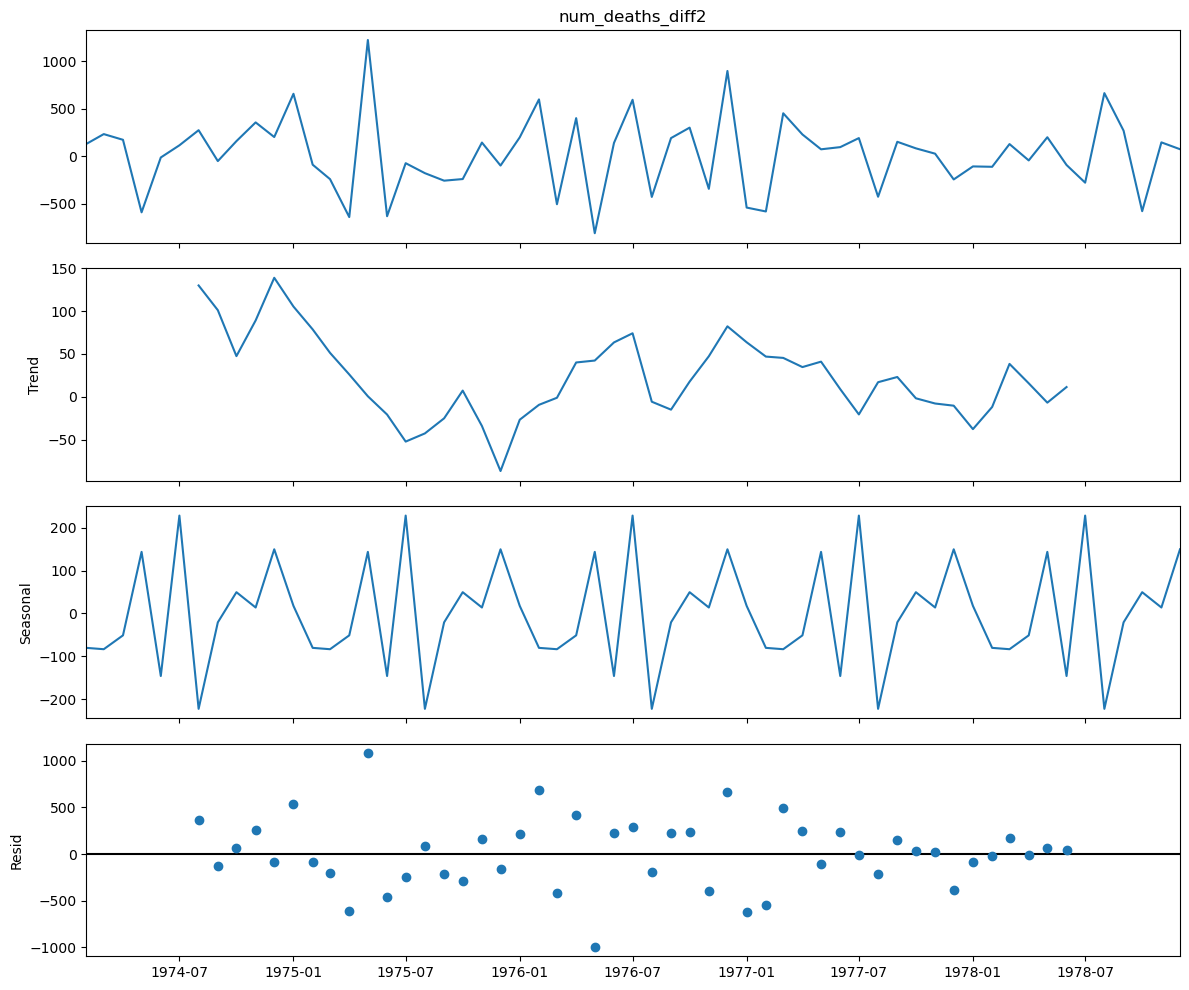

In [20]:
deaths['num_deaths_diff2'] = deaths['num_deaths_diff'] - deaths['num_deaths_diff'].shift(1)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths_diff2'][13:])[1])

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

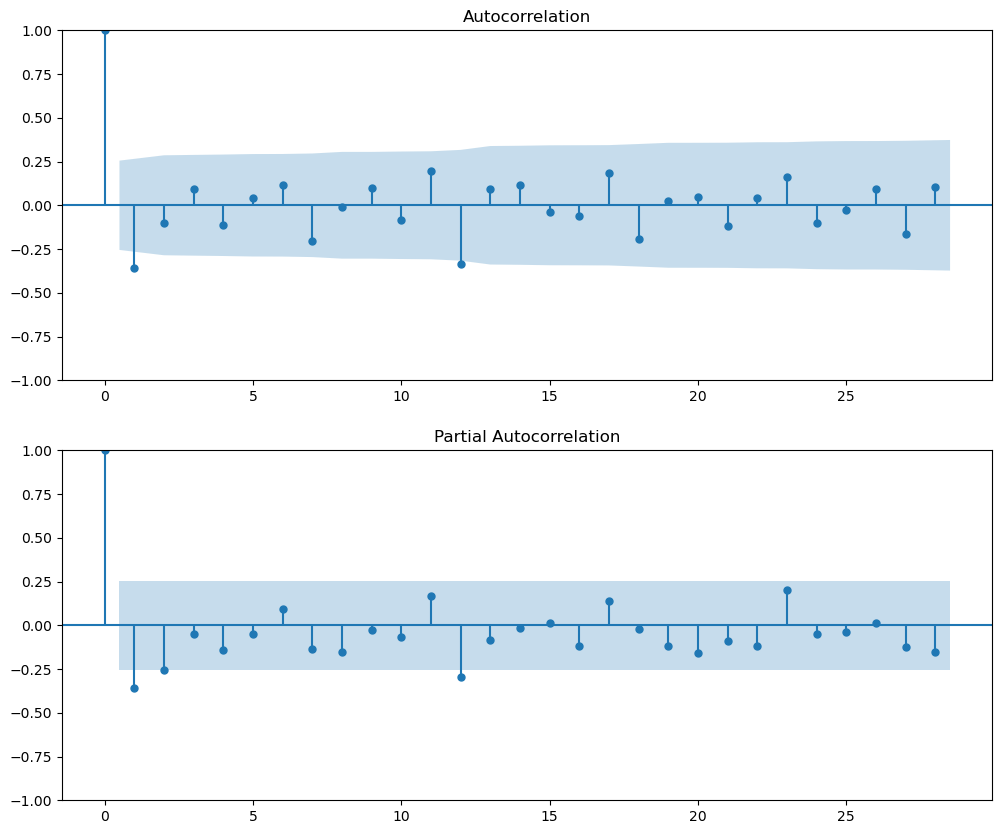

In [21]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(deaths['num_deaths_diff2'][13:].values.squeeze(), lags=28, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(deaths['num_deaths_diff2'][13:].values.squeeze(), lags=28, ax=ax);

Начальные приближения: Q=2, q=1, P=2, p=2

In [22]:
ps = range(0, 3)
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [23]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [36]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(deaths['num_deaths'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa

CPU times: user 1min 11s, sys: 2.51 s, total: 1min 14s
Wall time: 9.33 s


/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [37]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
19  (2, 0, 0, 1)  854.647098
10  (1, 0, 0, 1)  855.458079
24  (2, 0, 2, 0)  856.494101
20  (2, 0, 0, 2)  856.603171
22  (2, 0, 1, 1)  856.614483


Лучшая модель:

In [38]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           num_deaths   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -423.324
Date:                              Thu, 26 Oct 2023   AIC                            854.647
Time:                                      01:39:15   BIC                            862.957
Sample:                                  01-01-1973   HQIC                           857.891
                                       - 12-01-1978                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3724      0.112     -3.329      0.001      -0.592      -0.153
ar.L2         -0.19

Её остатки:

Критерий Стьюдента: p=0.274373
Критерий Дики-Фуллера: p=0.000000


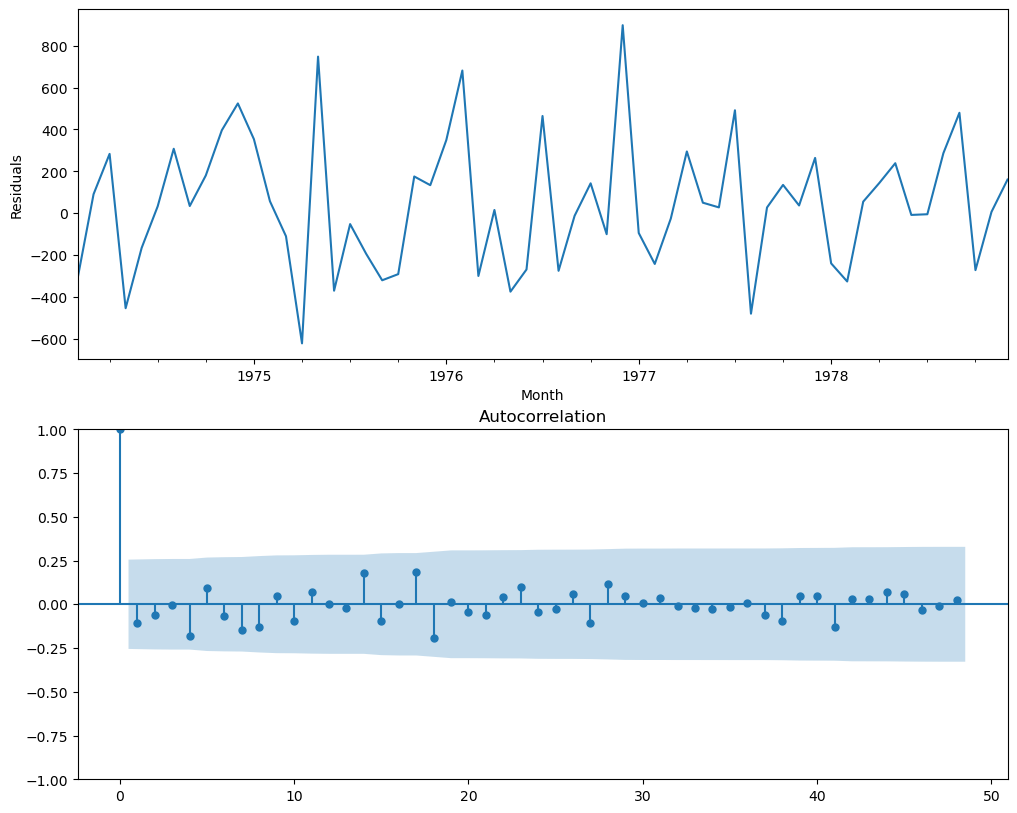

In [39]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

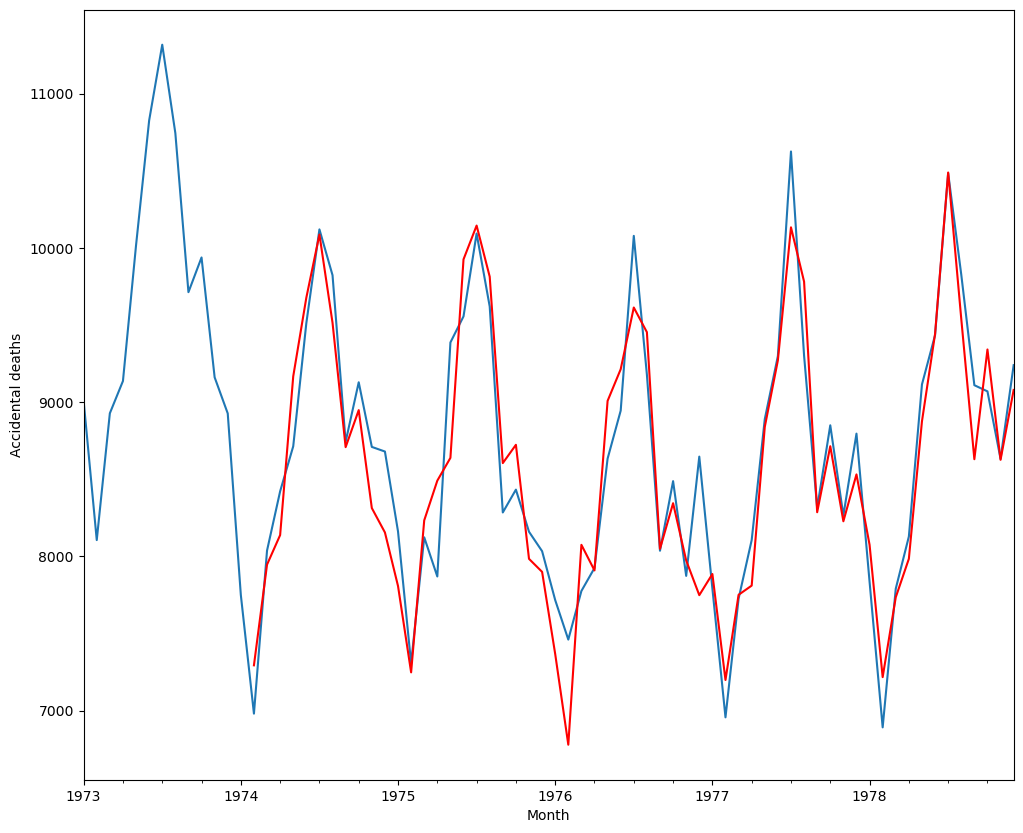

In [40]:
deaths['model'] = best_model.fittedvalues
deaths['num_deaths'].plot()
deaths['model'][13:].plot(color='r')
plt.ylabel('Accidental deaths');

### Прогноз

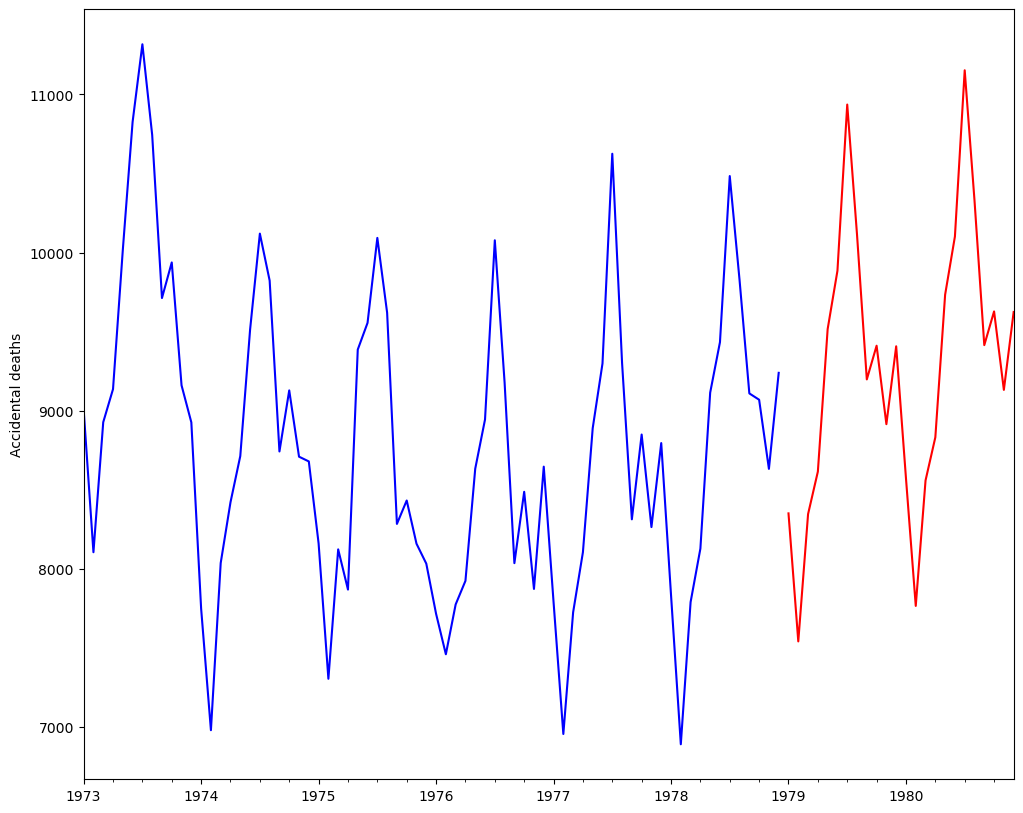

In [41]:
from dateutil.relativedelta import relativedelta
import datetime
deaths2 = deaths[['num_deaths']]
date_list = [datetime.datetime.strptime("1979-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=deaths2.columns)
deaths2 = pd.concat([deaths2, future])
deaths2['forecast'] = best_model.predict(start=72, end=100)

deaths2['num_deaths'].plot(color='b')
deaths2['forecast'].plot(color='r')
plt.ylabel('Accidental deaths');

In [35]:
deaths2

,num_deaths,forecast
1973-01-01,9007,NaN
1973-02-01,8106,NaN
1973-03-01,8928,NaN
1973-04-01,9137,NaN
1973-05-01,10017,NaN
...,...,...
1980-08-01,NaN,10330.485808
1980-09-01,NaN,9415.124015
1980-10-01,NaN,9628.331702
1980-11-01,NaN,9132.315349
